# Análisis del perfil crediticio de clientes bancarios



#### Autor: Samuel Arteaga López

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report
from imblearn.over_sampling import RandomOverSampler, ADASYN
from sklearn.utils import resample
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
import optuna
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

## 1. Carga del CSV

Aquí cargaremos una vista general del dataframe

In [2]:
df = pd.read_csv("csvs/loan_data.csv")
df.head()

,age,gender,education,income,yrs_exp,ownership,amount,purpose,int_rate,percent_income,cred_hist_length,risk_score,previous_loans,loan_status
0,22.0,female,Master,71948.0,0,RENT,35000.0,PERSONAL,16.02,0.49,3.0,561,No,1
1,21.0,female,High School,12282.0,0,OWN,1000.0,EDUCATION,11.14,0.08,2.0,504,Yes,0
2,25.0,female,High School,12438.0,3,MORTGAGE,5500.0,MEDICAL,12.87,0.44,3.0,635,No,1
3,23.0,female,Bachelor,79753.0,0,RENT,35000.0,MEDICAL,15.23,0.44,2.0,675,No,1
4,24.0,male,Master,66135.0,1,RENT,35000.0,MEDICAL,14.27,0.53,4.0,586,No,1


Echando un ojo de primeras podemos apreciar que los numeros son floats y el resto son datos categoricos excepto `previous_loans` y `loan_status` que funcionan como ``boolean``

## 2. Estudio de valores faltantes

Estructura de los datos, Datos faltantes, Valores únicos

Valores nulos

In [3]:
print(df.isnull().sum())

age                  0
gender               0
education            0
income               0
yrs_exp              0
ownership            0
amount               0
purpose             38
int_rate             0
percent_income       0
cred_hist_length     0
risk_score           0
previous_loans       0
loan_status          0
dtype: int64


Encontramos 38 valores nulos en purpose

Columnas del dataset

In [4]:
print(df.columns)

Index(['age', 'gender', 'education', 'income', 'yrs_exp', 'ownership',
       'amount', 'purpose', 'int_rate', 'percent_income', 'cred_hist_length',
       'risk_score', 'previous_loans', 'loan_status'],
      dtype='object')


Forma (filas, columnas)

In [5]:
print(df.shape)

(45000, 14)


Información general del dataframe

In [6]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45000 entries, 0 to 44999
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   age               45000 non-null  float64
 1   gender            45000 non-null  object 
 2   education         45000 non-null  object 
 3   income            45000 non-null  float64
 4   yrs_exp           45000 non-null  int64  
 5   ownership         45000 non-null  object 
 6   amount            45000 non-null  float64
 7   purpose           44962 non-null  object 
 8   int_rate          45000 non-null  float64
 9   percent_income    45000 non-null  float64
 10  cred_hist_length  45000 non-null  float64
 11  risk_score        45000 non-null  int64  
 12  previous_loans    45000 non-null  object 
 13  loan_status       45000 non-null  int64  
dtypes: float64(6), int64(3), object(5)
memory usage: 4.8+ MB
None


Descripción de todas las columnas

In [7]:
print(df.describe(include='all'))

                 age gender education        income       yrs_exp ownership  \
count   45000.000000  45000     45000  4.500000e+04  45000.000000     45000   
unique           NaN      3         5           NaN           NaN         5   
top              NaN   male  Bachelor           NaN           NaN      RENT   
freq             NaN  24841     13399           NaN           NaN     23443   
mean       27.764178    NaN       NaN  8.031905e+04      5.410333       NaN   
std         6.045108    NaN       NaN  8.042250e+04      6.063532       NaN   
min        20.000000    NaN       NaN  8.000000e+03      0.000000       NaN   
25%        24.000000    NaN       NaN  4.720400e+04      1.000000       NaN   
50%        26.000000    NaN       NaN  6.704800e+04      4.000000       NaN   
75%        30.000000    NaN       NaN  9.578925e+04      8.000000       NaN   
max       144.000000    NaN       NaN  7.200766e+06    125.000000       NaN   

              amount    purpose      int_rate  perc

Posibles duplicados del dataframe

In [8]:
print(df.duplicated())

0        False
1        False
2        False
3        False
4        False
         ...  
44995    False
44996    False
44997    False
44998    False
44999    False
Length: 45000, dtype: bool


Como podemos apreciar hay 38 valores nulos en la columna ``purpose``, hay 45000 filas y 14 columnas y no hay duplicados, además se ha adjuntado una breve descripción de cada columna. <br><br>
Dado que `purpose` tiene 38 valores faltantes y es una variable `categorical` hay que transformarla a datos numericos, a continuación borraremos los valores faltantes ya que representan un porcentaje muy bajo en el dataset

In [9]:
df.dropna(inplace=True)
print(df.shape)

(44962, 14)


Como podemos apreciar se han  borrado los valores faltantes

### Visualizacion de datos

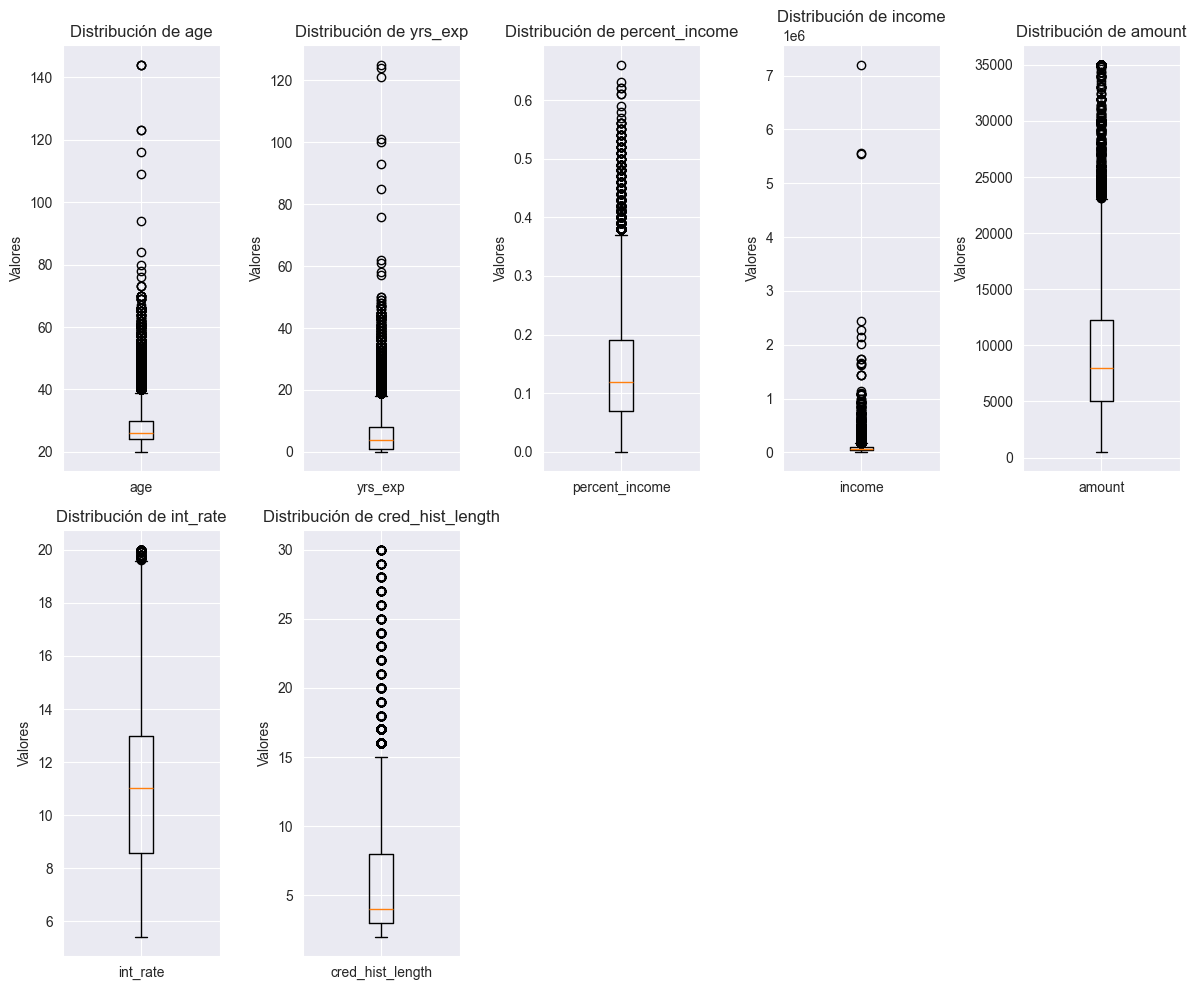

In [17]:
categorias = ['age', 'yrs_exp', 'percent_income', 'income', 'amount', 'int_rate', 'cred_hist_length']
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(12, 10))
axes = axes.flatten()
for i, var in enumerate(categorias):
 axes[i].boxplot(df[var], tick_labels=[var])
 axes[i].set_title(f'Distribución de {var}')
 axes[i].set_ylabel('Valores')
for j in range(len(categorias), len(axes)):
 axes[j].axis('off')
plt.tight_layout()
plt.show()


Como podemos apreciar en los gráficos `boxplot` encontramos algunos `outliers`, valores atípicos para los que presenta el fichero, se ha escogido todas las variables númericas excepto las targets `loan_status` y `risk_score` pues no presentan outliers

In [47]:
print(df['gender'].value_counts())
df['gender'] = df['gender'].replace("femal", "female")
print(df['gender'].value_counts())

gender
male      24825
female    20136
femal         1
Name: count, dtype: int64
gender
male      24825
female    20137
Name: count, dtype: int64


Aquí hemos realizado un cambio en un valor atípico en la columna genero, donde ponía `femal` se ha cambiado a `female`

In [31]:
# Filtrar y mostrar el registro donde ownership es "OWN"
print(df['ownership'].value_counts())
# df.drop('Gender_M', axis=1, inplace=True)


ownership
RENT        23412
MORTGAGE    18482
OWN          2950
OTHER         117
OWN             1
Name: count, dtype: int64


⚠️ `OWN` está repetido dos veces por lo que deberá de ser tratado ⚠️

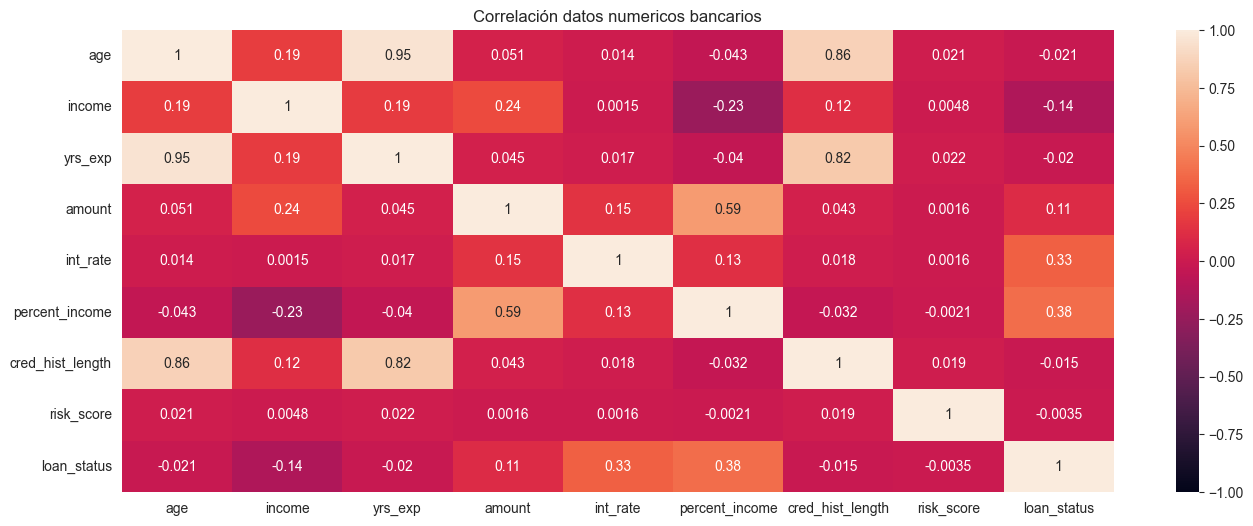

In [34]:
df_numericos = df.select_dtypes(include='number')
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(df_numericos.corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlación datos numericos bancarios')
plt.show()

Se ha realizado un mapa de calor para comprobar la relacion entre las variables numericas, estos datos serán tratados más adelante

## 3. Ingenieria de características TODO

Vamos a proceder a cambiar las variables categoricas `gender`, `education`, `ownership`, `purpose`, y `previous_loans`

In [18]:
df.head()

,age,gender,education,income,yrs_exp,ownership,amount,purpose,int_rate,percent_income,cred_hist_length,risk_score,previous_loans,loan_status
0,22.0,female,Master,71948.0,0,RENT,35000.0,PERSONAL,16.02,0.49,3.0,561,No,1
1,21.0,female,High School,12282.0,0,OWN,1000.0,EDUCATION,11.14,0.08,2.0,504,Yes,0
2,25.0,female,High School,12438.0,3,MORTGAGE,5500.0,MEDICAL,12.87,0.44,3.0,635,No,1
3,23.0,female,Bachelor,79753.0,0,RENT,35000.0,MEDICAL,15.23,0.44,2.0,675,No,1
4,24.0,male,Master,66135.0,1,RENT,35000.0,MEDICAL,14.27,0.53,4.0,586,No,1


In [8]:
df['smoke'] = df['smoke'].replace(['No', 'Yes'], [0, 1])

#df['purpose'].fillna(df['purpose'].mean(), inplace=True)
# df_con_dummies= pd.get_dummies(df, prefix='purpose', columns=['purpose'])
# print(df_con_dummies.dtypes)
#df_con_dummies.head()

# df_con_dummies.info()


age                          float64
gender                        object
education                     object
income                       float64
yrs_exp                        int64
ownership                     object
amount                       float64
int_rate                     float64
percent_income               float64
cred_hist_length             float64
risk_score                     int64
previous_loans                object
loan_status                    int64
purpose_DEBTCONSOLIDATION       bool
purpose_EDUCATION               bool
purpose_HOMEIMPROVEMENT         bool
purpose_MEDICAL                 bool
purpose_PERSONAL                bool
purpose_VENTURE                 bool
dtype: object
